In [4]:
from flame_analysis_model import *
from mpi4py import MPI
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.dpi": 150,  # higher resolution
    "font.size": 11,  # larger fonts
})

In [5]:
time_step = 212
phi = 0.40
lat_size = "100"
T_ref = 300
p_ref = 5e05

isolevels = [3, 3.5, 3.8, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.7]
n_isolevels = len(isolevels)

multiple_runs = False
n_RUN = 3

Soret_term = False
Soret_positive = False
post = True


2025-12-09 21:13:40,740 - Mesh - INFO - Initializing empty Mesh object.
2025-12-09 21:13:40,744 - Field - INFO - Initializing empty Field object
2025-12-09 21:13:40,746 - pynekread - INFO - Reading file: ../data/phi0.40/h400x100_ref/po_postPremix0.f00001
2025-12-09 21:13:40,805 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-12-09 21:13:40,805 - Mesh - INFO - Initializing common attributes.
2025-12-09 21:13:40,807 - Mesh - INFO - Getting vertices
2025-12-09 21:13:40,815 - Mesh - INFO - Getting edge centers
2025-12-09 21:13:40,899 - Mesh - INFO - Facet centers not available for 2D
2025-12-09 21:13:40,900 - Mesh - INFO - Mesh object initialized.
2025-12-09 21:13:40,901 - Mesh - INFO - Mesh data is of type: float64
2025-12-09 21:13:40,901 - Mesh - INFO - Elapsed time: 0.09653720003552735s
2025-12-09 21:13:40,902 - pynekread - INFO - Reading field data
2025-12-09 21:13:40,902 - pynekread - INFO - Overwriting fld object
2025-12-09 21:13:41,614 - pynekread - INFO - File re

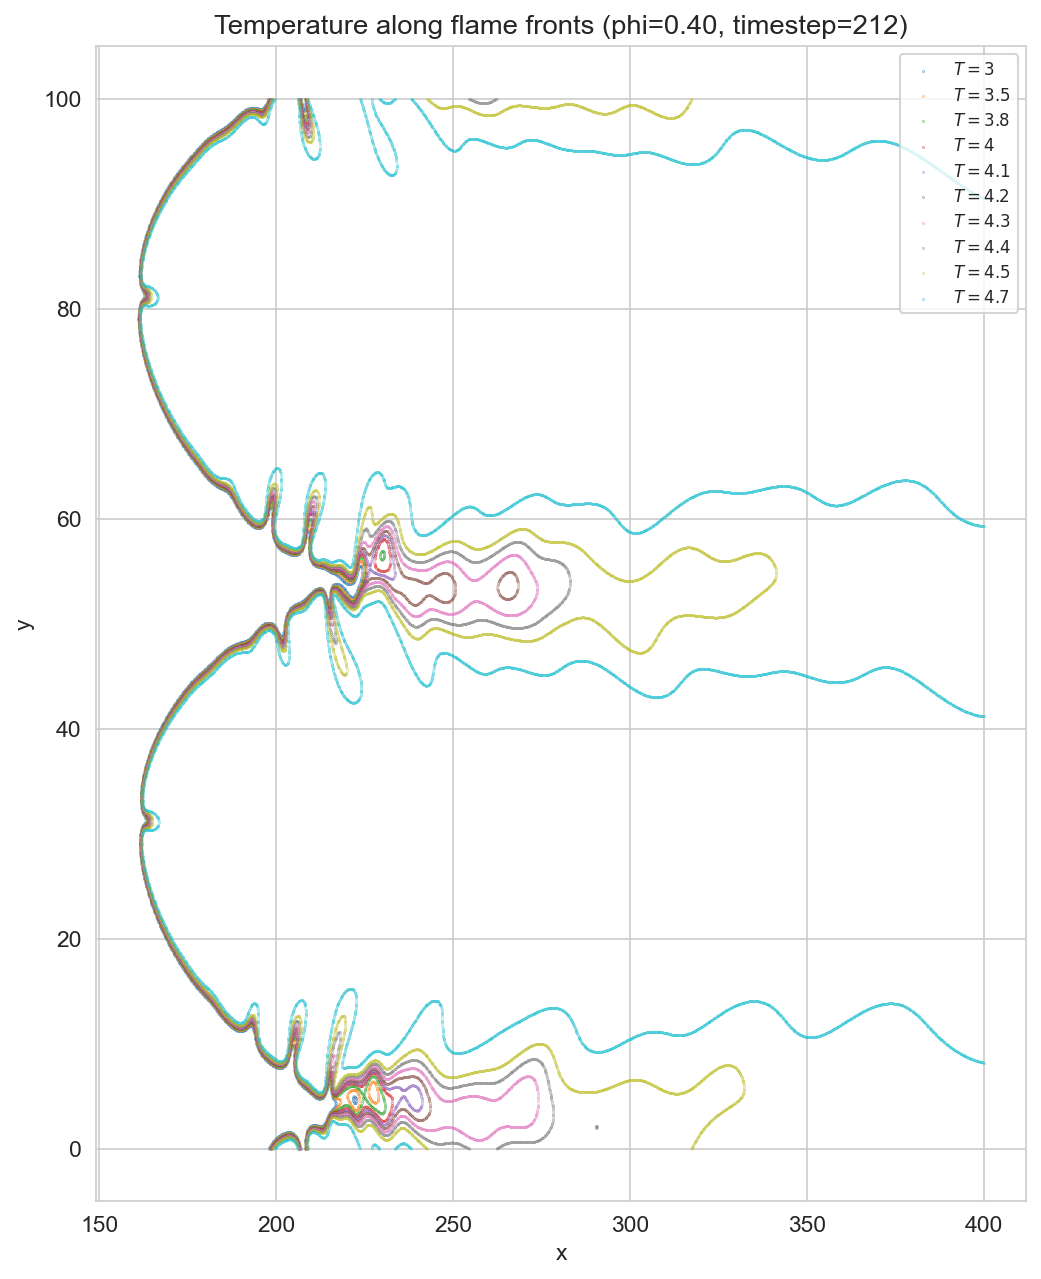

In [6]:
if (Soret_term & Soret_positive):
    folder_name = f"data/phi{phi:.2f}/h400x{lat_size}_ref_Soret_positive"
    save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret_positive"
elif Soret_term:
    folder_name = f"data/phi{phi:.2f}/h400x{lat_size}_ref_Soret"
    save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret"
else:
    folder_name = f"data/phi{phi:.2f}/h400x{lat_size}_ref"
    save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref"
if multiple_runs:
    folder_name += f"/RUN0{n_RUN}"
    save_name += f"/RUN0{n_RUN}"
if post:
    file_name = "po_postPremix"
else:
    file_name = "premix"


comm = MPI.COMM_WORLD
rank = comm.rank

# 2) Load dataset
scalars = [
    'H2',  #s1
    'O2',  #s2
    'H2O',  #s3
    'H',  #s4
    'O',  #s5
    'OH',  #s6
    'HO2',  #s7
    'H2O2',  #s8
    'N2',  #s9
    'HRR',  #s10
    'curvature',  #s11
    'stretch_rate',  #s12
    'DW_FDS',  #s13
    'abs_flame_prop_vel_normal',  #s14
    'flow_velocity_normal',  #s15
    'flow_velocity_tangential',  #s16
    'strain_rate',  #s17
    'tangential_strain_rate',  #s18
    'normal_strain_rate',  #s19
    'density_ratio_sigma',  #s20
    'gradT',  #s21
    'gradT_normal',  #s22
    'total_heat_conduction'  #s23
]

ds = SEMDataset(file_name=file_name, folder_name=folder_name, time_step=time_step, comm=MPI.COMM_WORLD,
                scalar_names=scalars)

df = ds.create_dataframe(
    compute_vel_jacobian=False,
    compute_vel_hessian=False,
    compute_reaction_rates=True,
    cantera_inputs=["../chemical_mech/BurkeH2.yaml", None, T_ref, p_ref]
)
fig, ax = plt.subplots(figsize=(8, 10), dpi=150)
for c in isolevels:
    # Extract flame front
    front = ds.extract_flame_front(
        c_level=c,
    )
    # Save to csv

    if post:
        save_file_name = f"/extracted_flame_front_post_{time_step}_iso_{c}.csv"
    else:
        save_file_name = f"/extracted_flame_front_{time_step}_iso_{c}.csv"
    save_name_iso = save_name + save_file_name
    front.to_csv(save_name_iso, index=False)

    # Plot
    ax.scatter(
        front["x"],
        front["y"],
        s=0.01,
        alpha=1,
        label=fr"$T={c}$"
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Temperature along flame fronts (phi={phi:.2f}, timestep={time_step})")
ax.legend(markerscale=2, fontsize=8)
ax.grid(True)

plt.show()

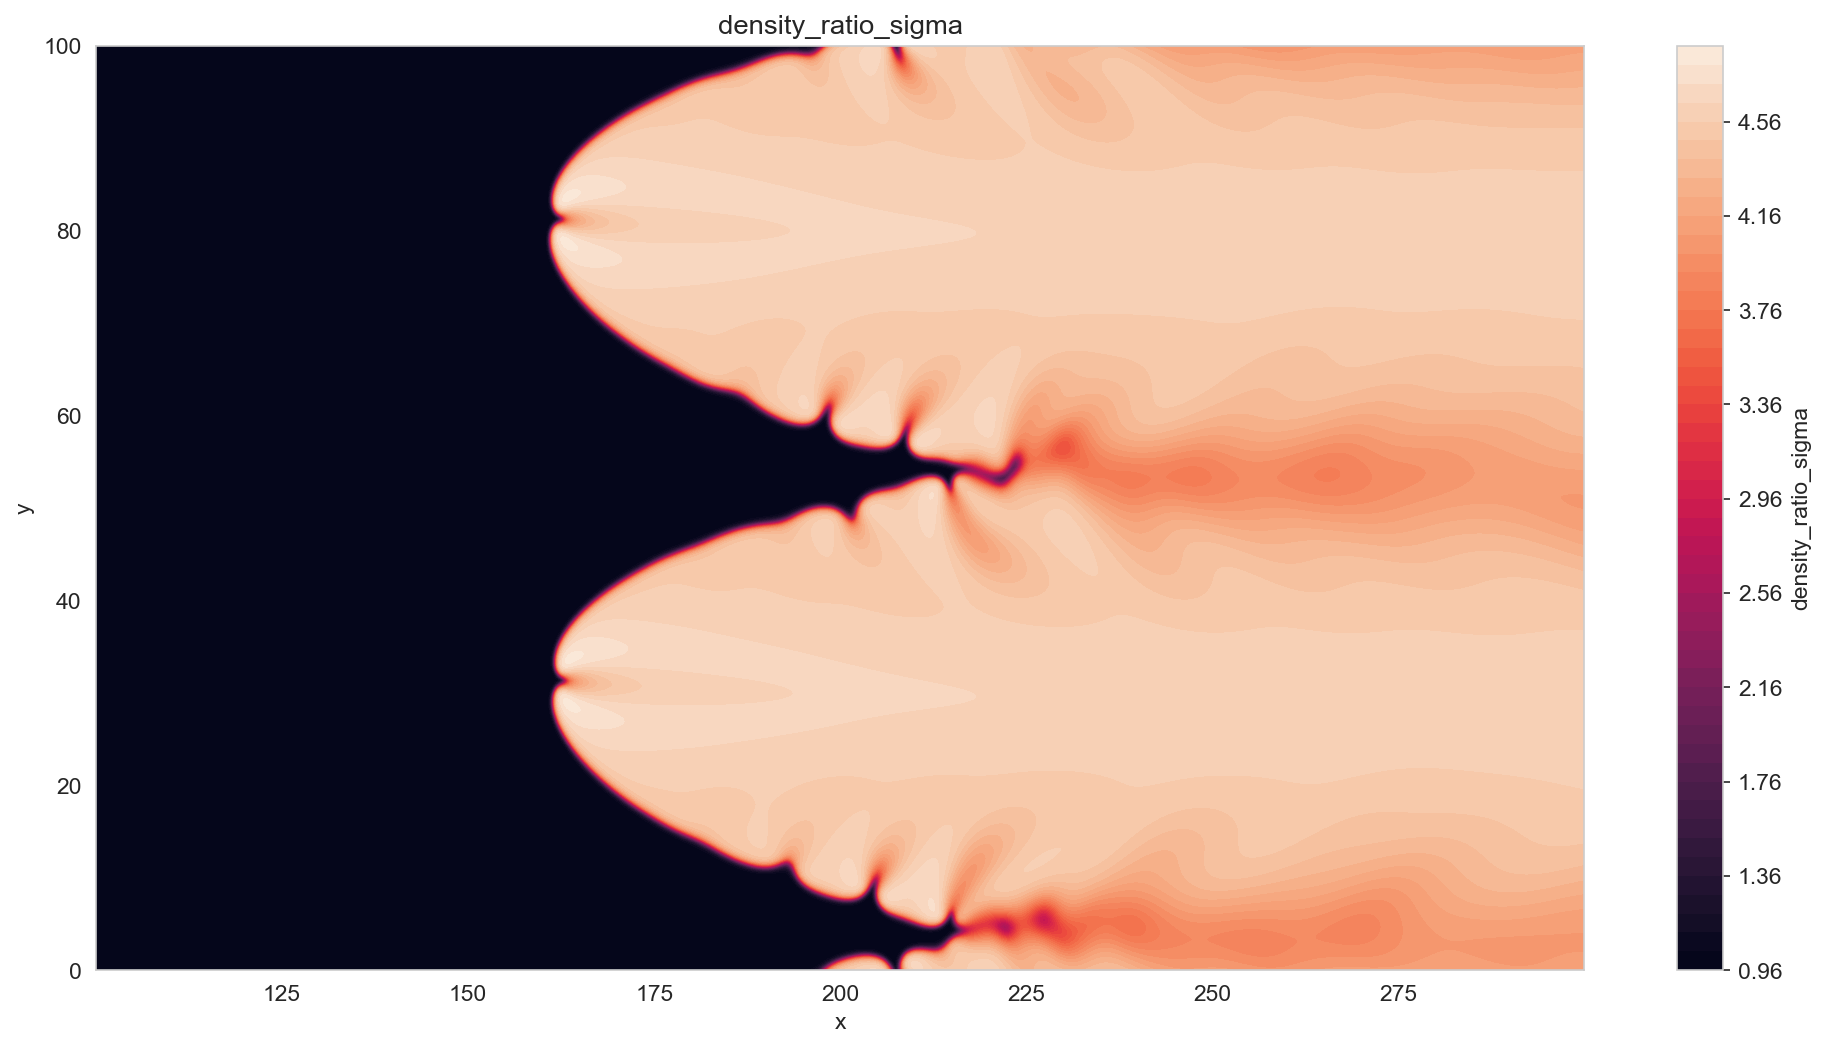

In [8]:
plot_var = "density_ratio_sigma"
df_sub = df[(df["x"]>100)& (df["x"]<300)]
plt.figure(figsize=(16, 8))
cf = plt.tricontourf(
    df_sub["x"], df_sub["y"], df_sub[plot_var],
    levels=50,
)
plt.xlabel("x")
plt.ylabel("y")
plt.title(str(plot_var))  # instead of empty f""
plt.colorbar(cf, label=plot_var)
plt.show()